Mounted at /content/gdrive

Loading antibiotics dataset...
Dataset shape: (350, 34)

Loading insurance dataset...
Dataset shape: (600, 31)

Analyzing Antibiotics Resistance dataset:


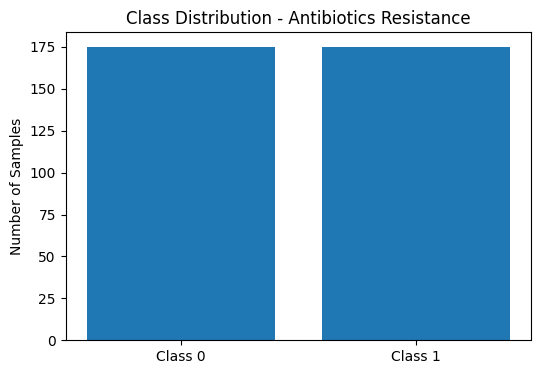

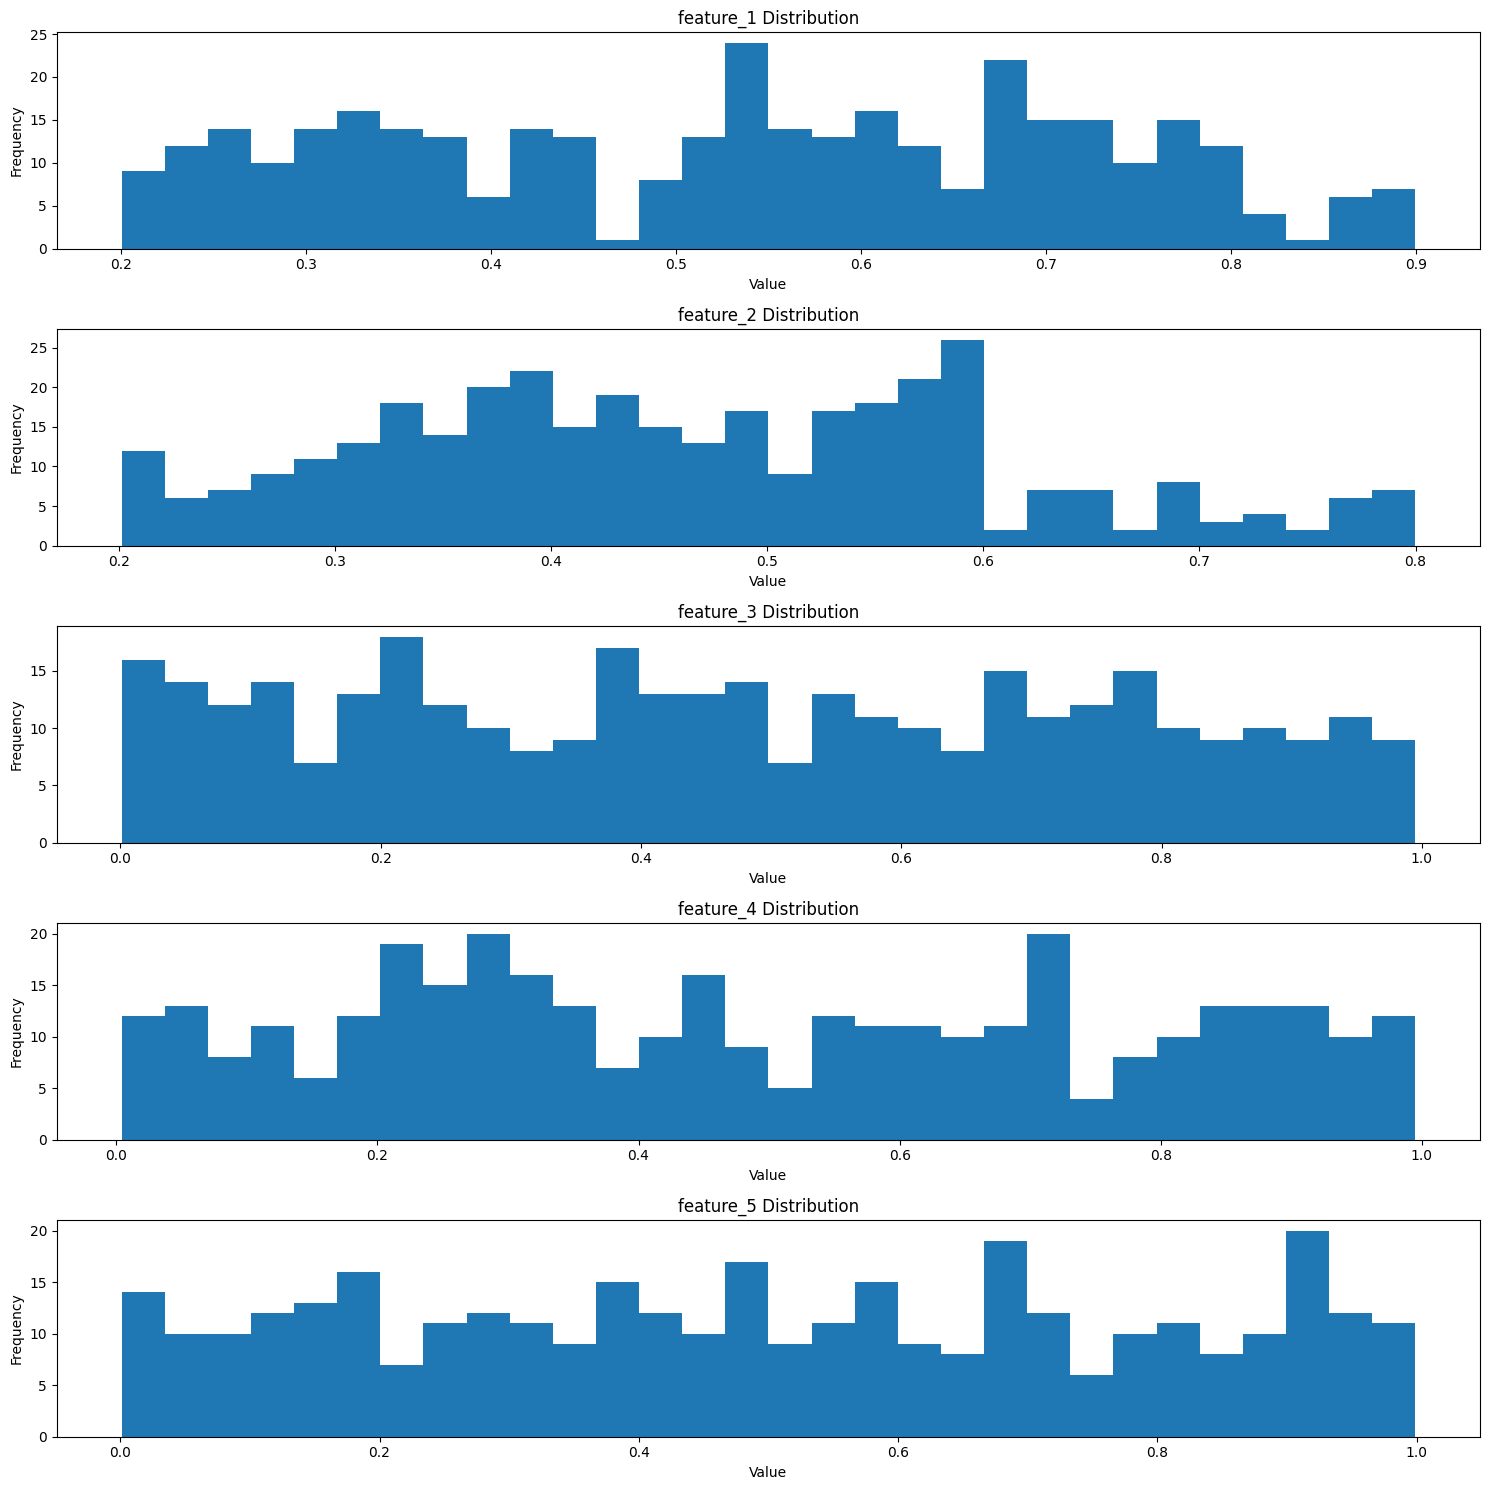


Analyzing feature importance...


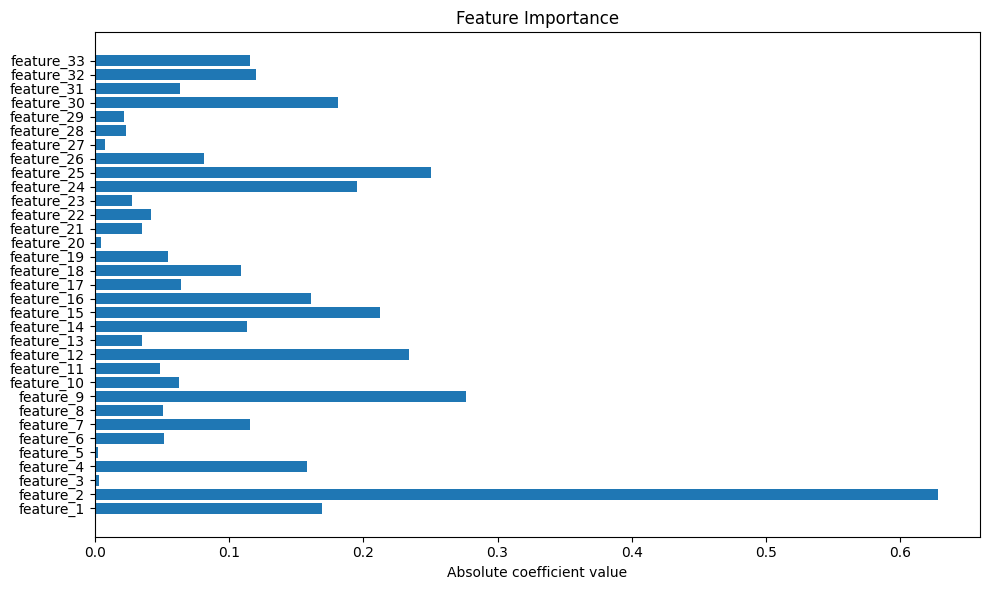


Performing model selection for Antibiotics Resistance - All Features:

Performing model selection for Antibiotics Resistance - All Features:
Learning rate 0.001: Accuracy = 0.4857 (±0.0171), Average Runtime = 0.1251 seconds
Learning rate 0.01: Accuracy = 0.5440 (±0.0137), Average Runtime = 0.0863 seconds
Learning rate 0.1: Accuracy = 0.6483 (±0.0144), Average Runtime = 0.0934 seconds

Best model: Learning rate = 0.1, Accuracy = 0.6483

Performing model selection for Antibiotics Resistance - Top 50% Features:

Performing model selection for Antibiotics Resistance - Top 50% Features:
Learning rate 0.001: Accuracy = 0.5260 (±0.0180), Average Runtime = 0.0721 seconds
Learning rate 0.01: Accuracy = 0.5911 (±0.0105), Average Runtime = 0.0890 seconds
Learning rate 0.1: Accuracy = 0.6831 (±0.0063), Average Runtime = 0.0726 seconds

Best model: Learning rate = 0.1, Accuracy = 0.6831

Performing model selection for Antibiotics Resistance - With New Interaction Feature:

Performing model selecti

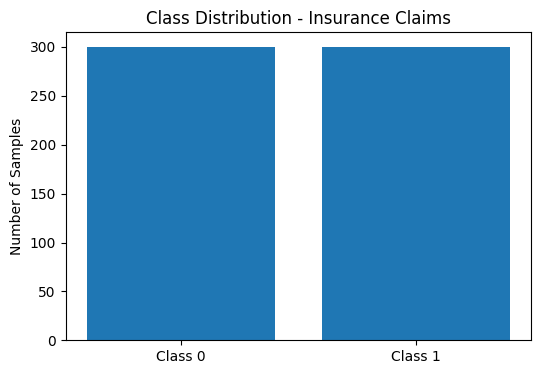

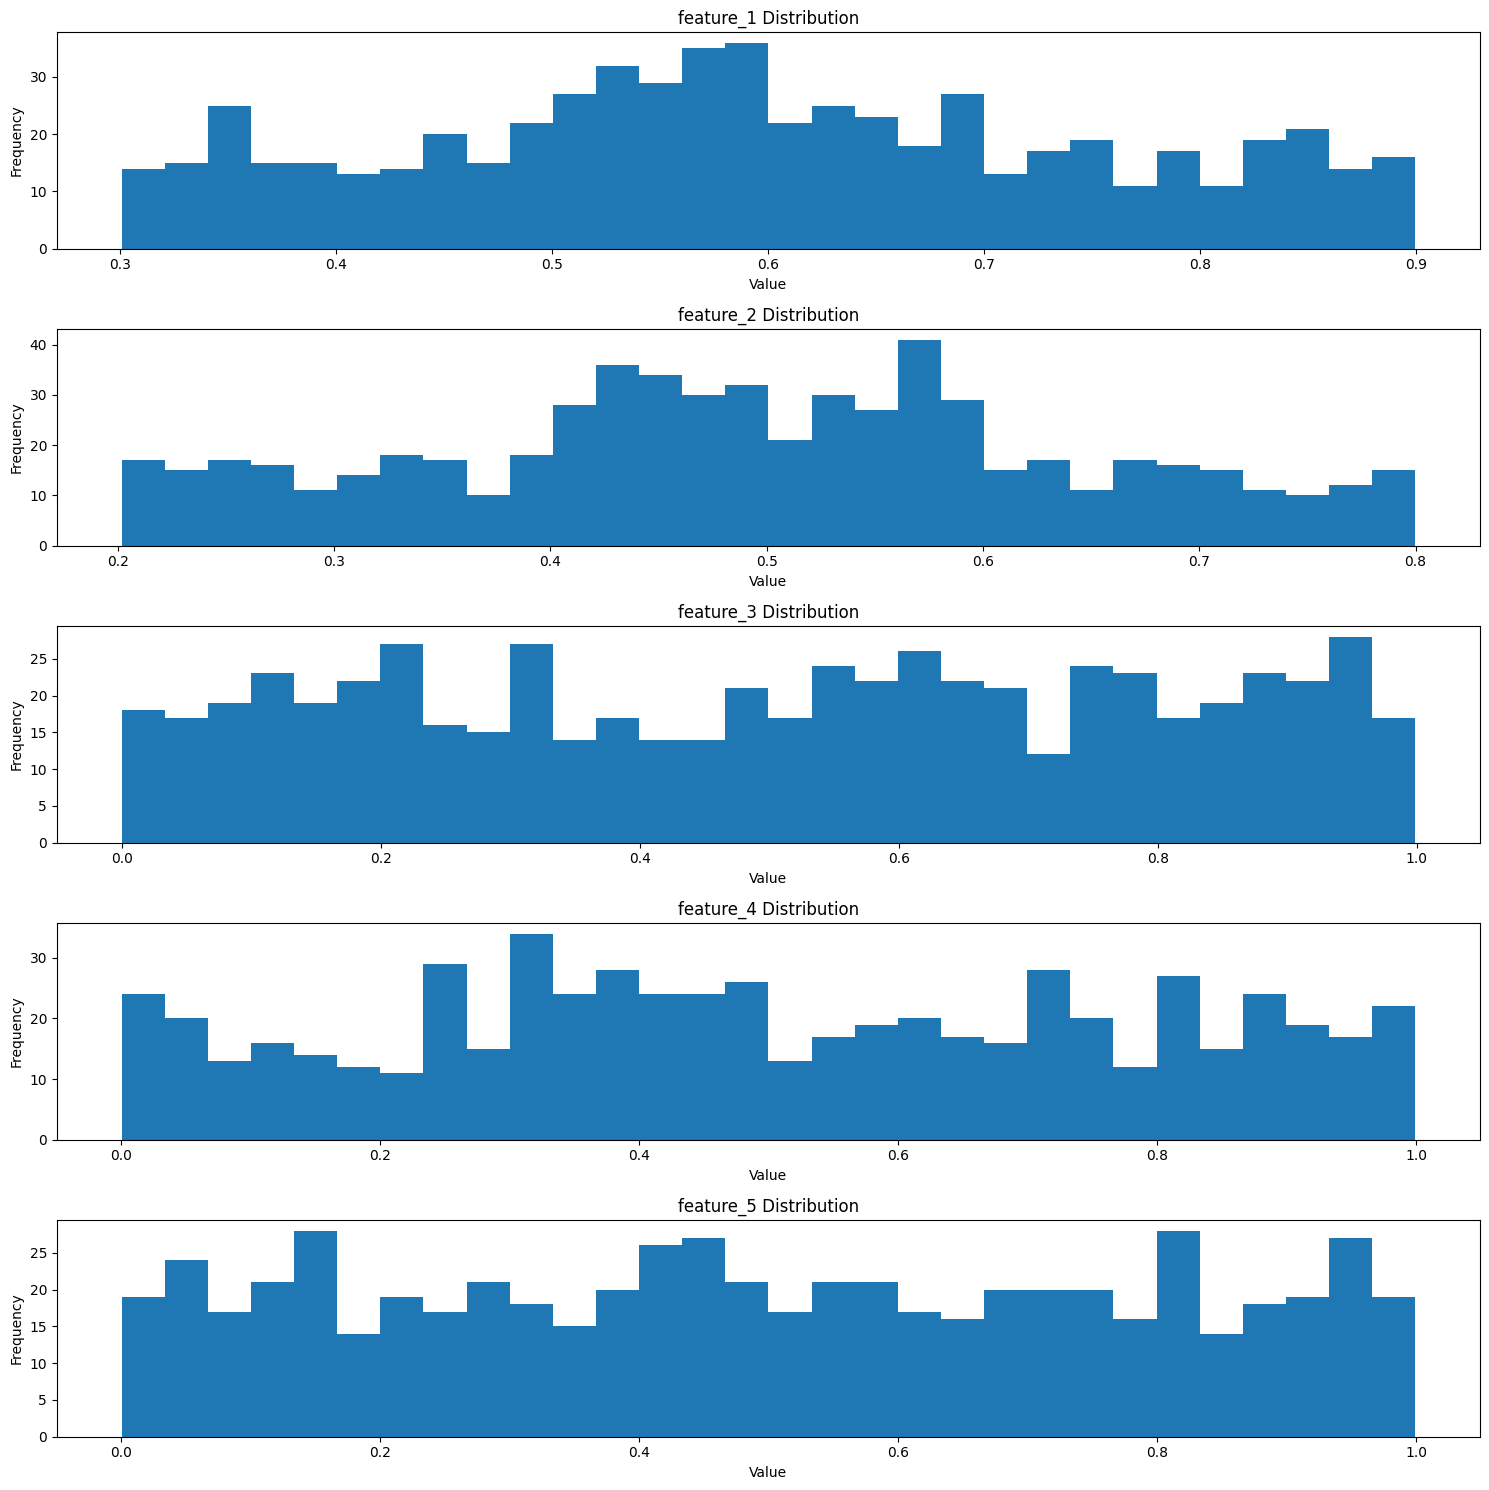


Analyzing feature importance...


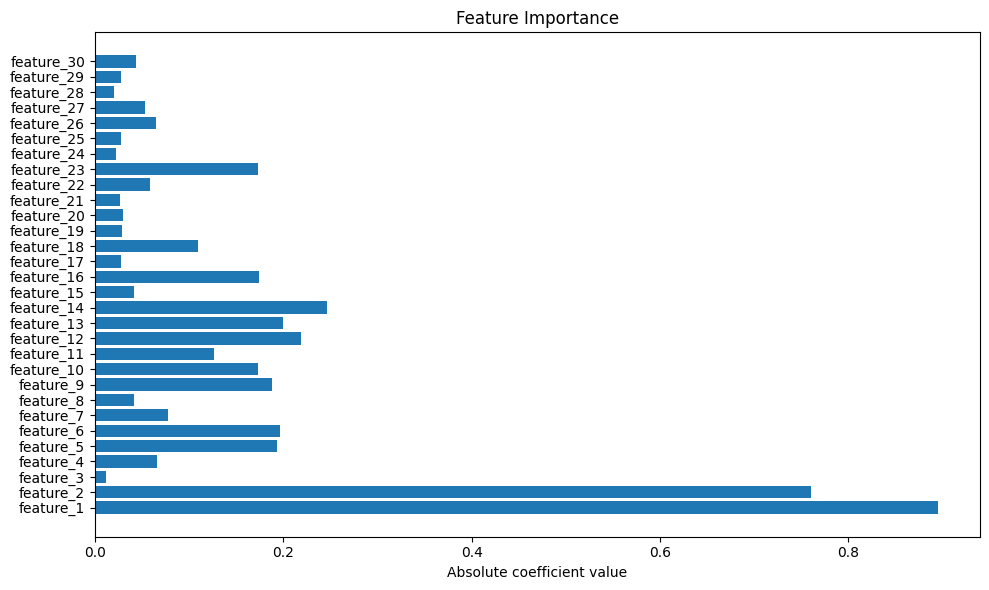


Performing model selection for Insurance Claims - All Features:

Performing model selection for Insurance Claims - All Features:
Learning rate 0.001: Accuracy = 0.5518 (±0.0141), Average Runtime = 0.1136 seconds
Learning rate 0.01: Accuracy = 0.7005 (±0.0094), Average Runtime = 0.1116 seconds
Learning rate 0.1: Accuracy = 0.8177 (±0.0079), Average Runtime = 0.1068 seconds

Best model: Learning rate = 0.1, Accuracy = 0.8177

Performing model selection for Insurance Claims - Top 50% Features:

Performing model selection for Insurance Claims - Top 50% Features:
Learning rate 0.001: Accuracy = 0.6207 (±0.0080), Average Runtime = 0.0917 seconds
Learning rate 0.01: Accuracy = 0.7523 (±0.0061), Average Runtime = 0.1058 seconds
Learning rate 0.1: Accuracy = 0.8320 (±0.0039), Average Runtime = 0.1060 seconds

Best model: Learning rate = 0.1, Accuracy = 0.8320

Performing model selection for Insurance Claims - With New Interaction Feature:

Performing model selection for Insurance Claims - With

In [1]:
from google.colab import drive
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time

# Mount Google Drive
drive.mount('/content/gdrive')

# Define file paths
antibiotics_path = '/content/gdrive/MyDrive/ECSE_551/Antibiotics_Resistance.csv'
insurance_path = '/content/gdrive/MyDrive/ECSE_551/Insurance_Claim.csv'

def load_and_prepare_data(filepath, dataset_type):

    # Load and prepare dataset with specific normalization for certain features

    data = pd.read_csv(filepath)
    if 'ID' in data.columns:
        data = data.drop(columns=['ID'])

    print(f"\nLoading {dataset_type} dataset...")
    print(f"Dataset shape: {data.shape}")

    X = data.iloc[:, :-1].values
    y = data.iloc[:, -1].values

    if dataset_type == 'antibiotics':
        y = np.where(y == 'R', 1, 0)
        X[:, 25:33] = (X[:, 25:33] - np.mean(X[:, 25:33], axis=0)) / np.std(X[:, 25:33], axis=0)
    elif dataset_type == 'insurance':
        y = np.where(y == 'Anomaly', 1, 0)
        X[:, 20:30] = (X[:, 20:30] - np.mean(X[:, 20:30], axis=0)) / np.std(X[:, 20:30], axis=0)

    return X, y, data.columns[:-1]

def plot_class_distribution(y, dataset_name):

    # Plot the class distribution for a given dataset.

    unique, counts = np.unique(y, return_counts=True)
    plt.figure(figsize=(6, 4))
    plt.bar(['Class 0', 'Class 1'], counts)
    plt.title(f'Class Distribution - {dataset_name}')
    plt.ylabel('Number of Samples')
    plt.show()

def plot_feature_distributions(X, feature_names, dataset_name):

    # Plot the distribution of the first few features in the dataset.

    n_features = min(5, X.shape[1])
    plt.figure(figsize=(15, 3*n_features))

    for i in range(n_features):
        plt.subplot(n_features, 1, i+1)
        plt.hist(X[:, i], bins=30)
        plt.title(f'{feature_names[i]} Distribution')
        plt.xlabel('Value')
        plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

class LogisticRegression:
    def __init__(self, learning_rate=0.01, iterations=1000):
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.weights = None
        self.bias = None

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-np.clip(z, -500, 500)))

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        for _ in range(self.iterations):
            linear_model = np.dot(X, self.weights) + self.bias
            y_predicted = self.sigmoid(linear_model)

            dw = (1 / n_samples) * np.dot(X.T, (y_predicted - y))
            db = (1 / n_samples) * np.sum(y_predicted - y)

            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

        return self

    def predict(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        y_predicted = self.sigmoid(linear_model)
        return (y_predicted > 0.5).astype(int)

def Accu_eval(y_true, y_pred):
    """
    Evaluate accuracy as specified in project requirements
    """
    return np.mean(y_true == y_pred)

def k_fold_split(X, y, n_splits=10, random_state=None):
    """
    Generate indices for k-fold cross-validation
    """
    n_samples = len(y)
    indices = np.arange(n_samples)

    if random_state is not None:
        np.random.seed(random_state)

    np.random.shuffle(indices)
    fold_size = n_samples // n_splits

    for i in range(n_splits):
        start = i * fold_size
        end = start + fold_size if i < n_splits - 1 else n_samples
        test_indices = indices[start:end]
        train_indices = np.concatenate([indices[:start], indices[end:]])
        yield train_indices, test_indices

def model_selection(X, y, learning_rates, iterations, dataset_name):
    """
    Perform model selection by running 10-fold cross validation for each model (learning rate)
    """
    print(f"\nPerforming model selection for {dataset_name}:")

    results = []

    for lr in learning_rates:
        model_accuracies = []
        model_runtimes = []

        for _ in range(10):  # Run 10-fold CV 10 times for each model
            fold_accuracies = []
            fold_runtimes = []

            for train_indices, test_indices in k_fold_split(X, y, n_splits=10, random_state=np.random.randint(1000)):
                X_train, X_test = X[train_indices], X[test_indices]
                y_train, y_test = y[train_indices], y[test_indices]

                start_time = time()
                model = LogisticRegression(learning_rate=lr, iterations=iterations)
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                end_time = time()

                accuracy = Accu_eval(y_test, y_pred)
                runtime = end_time - start_time

                fold_accuracies.append(accuracy)
                fold_runtimes.append(runtime)

            model_accuracies.append(np.mean(fold_accuracies))
            model_runtimes.append(np.mean(fold_runtimes))

        mean_acc = np.mean(model_accuracies)
        std_acc = np.std(model_accuracies)
        mean_runtime = np.mean(model_runtimes)

        results.append({
            'learning_rate': lr,
            'mean_accuracy': mean_acc,
            'std_accuracy': std_acc,
            'mean_runtime': mean_runtime
        })

        print(f"Learning rate {lr}: Accuracy = {mean_acc:.4f} (±{std_acc:.4f}), Average Runtime = {mean_runtime:.4f} seconds")

    best_model = max(results, key=lambda x: x['mean_accuracy'])
    print(f"\nBest model: Learning rate = {best_model['learning_rate']}, Accuracy = {best_model['mean_accuracy']:.4f}")

    return best_model['learning_rate'], best_model['mean_accuracy']

def feature_importance(X, y, feature_names):

    # Analyze feature importance using the logistic regression coefficients

    model = LogisticRegression(iterations=2000).fit(X, y)
    importance = np.abs(model.weights)

    plt.figure(figsize=(10, 6))
    plt.barh(range(len(importance)), importance)
    plt.yticks(range(len(importance)), feature_names)
    plt.xlabel('Absolute coefficient value')
    plt.title('Feature Importance')
    plt.tight_layout()
    plt.show()

    return importance

def train_test_split(X, y, test_size=0.2, random_state=None):

    # Split the data into training and test sets.

    if random_state is not None:
        np.random.seed(random_state)

    n_samples = len(y)
    indices = np.random.permutation(n_samples)
    test_size = int(test_size * n_samples)

    test_indices = indices[:test_size]
    train_indices = indices[test_size:]

    X_train, X_test = X[train_indices], X[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]

    return X_train, X_test, y_train, y_test

def run_overall():
    datasets = [
        ('Antibiotics Resistance', load_and_prepare_data(antibiotics_path, 'antibiotics')),
        ('Insurance Claims', load_and_prepare_data(insurance_path, 'insurance'))
    ]

    learning_rates = [0.001, 0.01, 0.1]
    iterations = 2000

    for dataset_name, (X, y, features) in datasets:
        print(f"\nAnalyzing {dataset_name} dataset:")

        # Perform statistical analysis
        plot_class_distribution(y, dataset_name)
        plot_feature_distributions(X, features, dataset_name)

        # Analyze feature importance
        print("\nAnalyzing feature importance...")
        importance = feature_importance(X, y, features)

        # Prepare feature subsets
        top_50_features = np.argsort(importance)[::-1][:len(importance)//2]
        X_top_50 = X[:, top_50_features]

        top_2_features = np.argsort(importance)[::-1][:2]
        new_feature = X[:, top_2_features[0]] * X[:, top_2_features[1]]
        X_with_interaction = np.column_stack((X, new_feature))

        # Model selection for each feature subset
        feature_sets = [
            ("All Features", X),
            ("Top 50% Features", X_top_50),
            ("With New Interaction Feature", X_with_interaction)
        ]

        best_models = []
        for feature_set_name, X_set in feature_sets:
            print(f"\nPerforming model selection for {dataset_name} - {feature_set_name}:")
            best_lr, best_acc = model_selection(X_set, y, learning_rates, iterations, f"{dataset_name} - {feature_set_name}")
            best_models.append((feature_set_name, best_lr, X_set, best_acc))

        # Select the overall best model
        best_model = max(best_models, key=lambda x: x[3])
        print(f"\nOverall best model for {dataset_name}: {best_model[0]} with learning rate {best_model[1]}")

        # Final evaluation on test set
        X_train, X_test, y_train, y_test = train_test_split(best_model[2], y, test_size=0.2, random_state=42)

        model = LogisticRegression(learning_rate=best_model[1], iterations=iterations)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        accuracy = Accu_eval(y_test, y_pred)
        print(f"{dataset_name} - Final Test Accuracy: {accuracy:.4f}")

if __name__ == "__main__":
    run_overall()